In [141]:
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import jax.numpy as jnp
import os
import numpy as np

from jax import jit, grad, vmap, jacfwd
from jax.scipy.stats import gaussian_kde as kde
from jax.scipy.stats import multivariate_normal as mvn
import jax
cpu = jax.devices("cpu")[0]
try:
    gpu = jax.devices("cuda")[0]
except:
    gpu = cpu
jnp.set_printoptions(precision=4)

try:
    from lqrax import LQR
except:
    %pip install lqrax
    from lqrax import LQR

In [142]:
# mean1 = jnp.array([0.3, 0.5])
# cov1 = jnp.array([
#     [0.002, 0.0],
#     [0.0, 0.04]
# ])

# mean2 = jnp.array([0.5, 0.5])
# cov2 = jnp.array([
#     [0.02, -0.018],
#     [-0.018, 0.02]
# ])

# mean3 = jnp.array([0.7, 0.5])
# cov3 = jnp.array([
#     [0.002, 0.0],
#     [0.0, 0.04]
# ])

# w1, w2, w3 = 0.34, 0.34, 0.33

In [143]:
# A different target distribution
mean1 = jnp.array([0.35, 0.5])
cov1 = jnp.array([
    [0.003, 0.0],
    [0.0, 0.05]
])

mean2 = jnp.array([0.5, 0.25])
cov2 = jnp.array([
    [0.02, -0.0],
    [-0.0, 0.002]
])

mean3 = jnp.array([0.65, 0.5])
cov3 = jnp.array([
    [0.003, 0.0],
    [0.0, 0.05]
])

w1, w2, w3 = 0.5, 0.25, 0.5

In [144]:
def pdf(x):
    # only evaluate the first two dimensions (2D position)
    val1 = w1 * mvn.pdf(x[:2], mean1, cov1)
    val2 = w2 * mvn.pdf(x[:2], mean2, cov2)
    val3 = w3 * mvn.pdf(x[:2], mean3, cov3)
    return val1 + val2 + val3


def log_pdf(x):
    return jnp.log(pdf(x))


score_pdf = grad(log_pdf)

In [145]:
# Density grid for visualizing PDF
grids_x, grids_y = jnp.meshgrid(
    jnp.linspace(0.0, 1.0, 100),
    jnp.linspace(0.0, 1.0, 100)
)
grids = jnp.array([grids_x.ravel(), grids_y.ravel()]).T
print(f'grids.shape: {grids.shape}')

grids.shape: (10000, 2)


In [146]:
# Less dense grid for visualizing score function (vector field)
grids_x2, grids_y2 = jnp.meshgrid(
    jnp.linspace(0.1, 0.9, 30),
    jnp.linspace(0.1, 0.9, 30)
)
grids2 = jnp.array([grids_x2.ravel(), grids_y2.ravel()]).T
print(f'grids2.shape: {grids2.shape}')

grids2.shape: (900, 2)


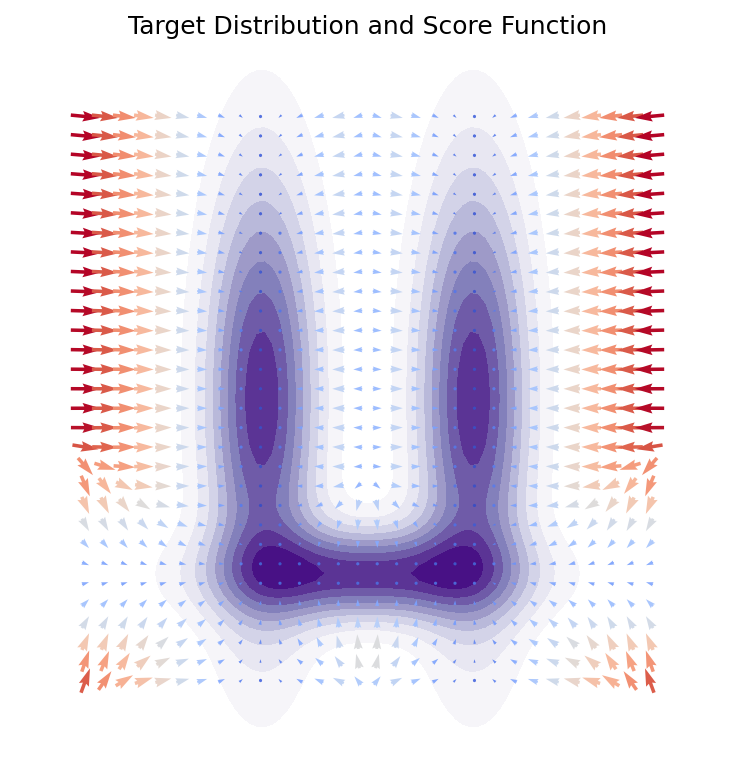

In [147]:
pdf_grids = vmap(pdf)(grids).reshape(grids_x.shape)
pdf_grids = np.array(pdf_grids)
# cannot reshape here because it is a vector field
score_grids = vmap(score_pdf)(grids2)

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title("Target Distribution and Score Function")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
clevels = np.linspace(pdf_grids.min(), pdf_grids.max(), 11)
ax.contourf(grids_x, grids_y, pdf_grids, levels=clevels[1:], cmap='Purples')
ax.quiver(
    grids_x2, grids_y2,
    score_grids[:, 0], score_grids[:, 1],
    np.sqrt(np.sum(score_grids**2, axis=-1)),
    cmap="coolwarm",
    scale=2000.0,
    width=0.005,
    pivot="mid",
)
plt.show()
plt.close()

In [148]:
dt = 0.05
tsteps = 200
T = dt * tsteps

_x0 = jnp.array([0.1, 0.2])
x0 = jnp.array([
    _x0[0],
    _x0[1],
    2.0 * (0.5-_x0[0]) / T,
    2.0 * (0.5-_x0[1]) / T,
])
u_traj = jnp.zeros((tsteps, 2))

In [149]:
class PointMassLQR(LQR):
    def __init__(self, dt, x_dim, u_dim, Q, R):
        super().__init__(dt, x_dim, u_dim, Q, R)

    def dyn(self, xt, ut):
        return jnp.array([xt[2], xt[3], ut[0], ut[1]])

In [150]:
Q = jnp.diag(jnp.array([1.0, 1.0, 0.001, 0.001]))
R = jnp.diag(jnp.array([0.01, 0.01]))
pointmass_lqr = PointMassLQR(dt=dt, x_dim=4, u_dim=2, Q=Q, R=R)

# lqr solving on CPU is faster
linearize_dyn = jit(pointmass_lqr.linearize_dyn, device=cpu)
solve_lqr = jit(pointmass_lqr.solve, device=cpu)

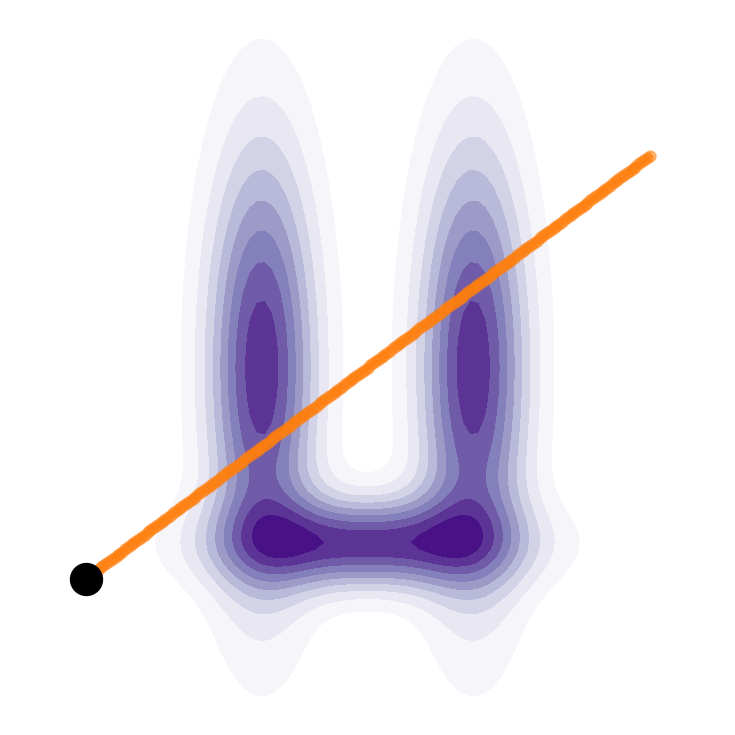

In [151]:
x_traj = pointmass_lqr.dyn_scan(x0, u_traj)

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
clevels = np.linspace(pdf_grids.min(), pdf_grids.max(), 11)
ax.contourf(grids_x, grids_y, pdf_grids, levels=clevels[1:], cmap='Purples')
ax.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

In [152]:
# Define function to calculate Stein variational gradient
def kernel(x1, x2, h):
    # same as in the pdf function, only evaluate the first two dimensions
    return jnp.exp(-1.0 * jnp.sum(jnp.square(x1[:2]-x2[:2])) / h)


d_kernel = jax.grad(kernel, argnums=(0))


def stein_grad_unit(x1, x2, h):
    val = kernel(x2, x1, h) * score_pdf(x2) + d_kernel(x2, x1, h)
    return val


def stein_grad_state(x, x_traj, h):
    vals = jax.vmap(stein_grad_unit, in_axes=(None, 0, None))(x, x_traj, h)
    return jnp.mean(vals, axis=0)


def stein_grad(traj, h):
    return jax.vmap(stein_grad_state, in_axes=(0, None, None))(traj, traj, h)


# Stein variational gradient on GPU is faster
stein_grad = jax.jit(stein_grad, device=gpu)

stein_dx_traj .shape: (200, 4) == x_traj.shape: (200, 4)


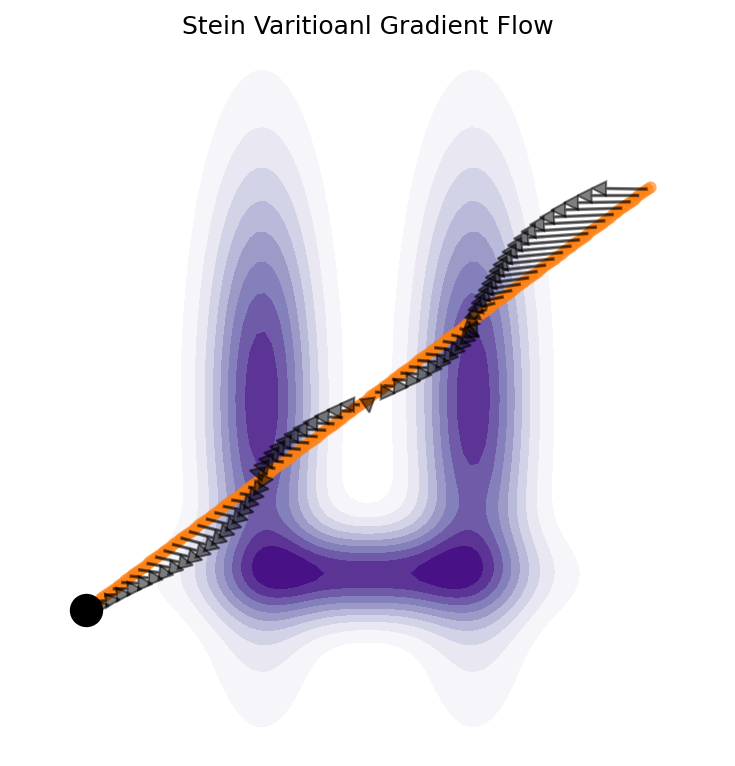

In [153]:
stein_dx_traj = stein_grad(x_traj, h=0.01)
stein_dx_traj = np.array(stein_dx_traj)
# note that the dimension of the descent direction matches the trajectory
print(
    f'stein_dx_traj .shape: {stein_dx_traj.shape} == x_traj.shape: {x_traj.shape}')

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title('Stein Varitioanl Gradient Flow')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
clevels = np.linspace(pdf_grids.min(), pdf_grids.max(), 11)
ax.contourf(grids_x, grids_y, pdf_grids, levels=clevels[1:], cmap='Purples')
ax.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
for t in range(len(x_traj[::3])):
    vis_scale = 0.01
    ax.arrow(
        x_traj[::3][t, 0], x_traj[::3][t, 1],
        vis_scale * stein_dx_traj[::3][t, 0],
        vis_scale * stein_dx_traj[::3][t, 1],
        width=0.002,
        head_width=0.02,
        head_length=0.02,
        alpha=0.5,
        color='k',
        zorder=2
    )
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

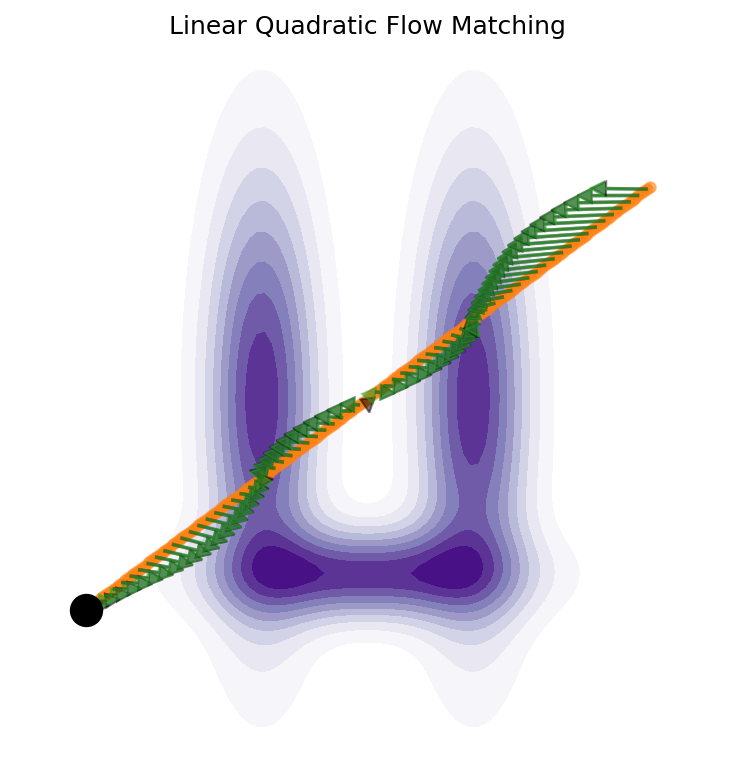

In [154]:
# Solve the LQ flow matching problem for current iteration
x_traj, A_traj, B_traj = linearize_dyn(x0, u_traj)
z0 = jnp.zeros(4)
v_traj, z_traj = solve_lqr(z0, A_traj, B_traj, stein_dx_traj)

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title('Linear Quadratic Flow Matching')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
clevels = np.linspace(pdf_grids.min(), pdf_grids.max(), 11)
ax.contourf(grids_x, grids_y, pdf_grids, levels=clevels[1:], cmap='Purples')
ax.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
for t in range(len(x_traj[::3])):
    vis_scale = 0.01
    ax.arrow(
        x_traj[::3][t, 0], x_traj[::3][t, 1],
        vis_scale * stein_dx_traj[::3][t, 0],
        vis_scale * stein_dx_traj[::3][t, 1],
        width=0.002,
        head_width=0.02,
        head_length=0.02,
        alpha=0.5,
        color='k',
        zorder=2,
    )
    ax.arrow(
        x_traj[::3][t, 0], x_traj[::3][t, 1],
        vis_scale * z_traj[::3][t, 0],
        vis_scale * z_traj[::3][t, 1],
        width=0.002,
        head_width=0.02,
        head_length=0.02,
        alpha=0.5,
        color='C2',
        zorder=2
    )
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

  0%|          | 0/500 [00:00<?, ?it/s]

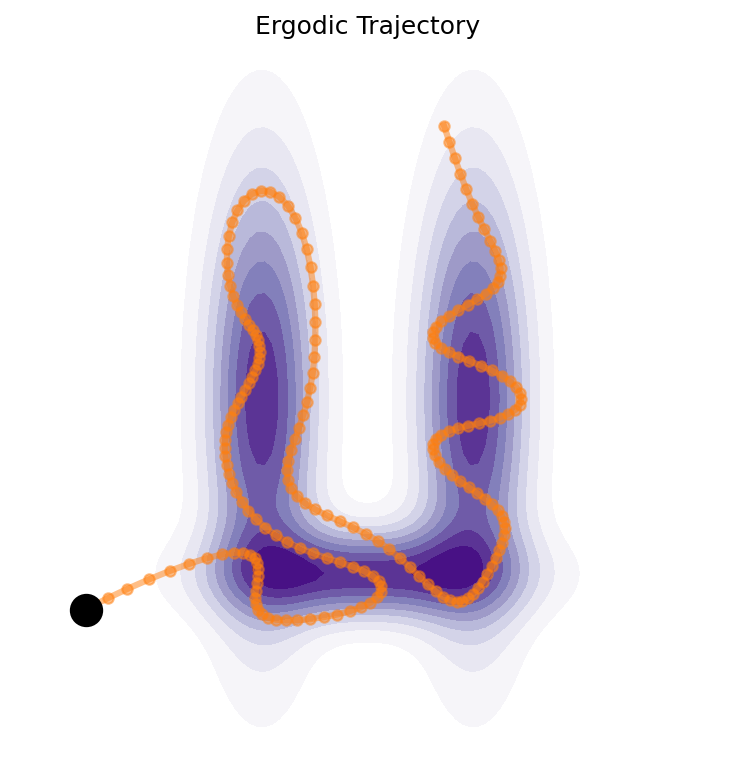

In [155]:
# Solve the flow matching ergodic coverage problem
z0 = jnp.zeros(4)
step_size = 0.01
num_iters = 500
x_traj_list = []
for i in tqdm(range(num_iters)):
    x_traj, A_traj, B_traj = linearize_dyn(x0, u_traj)
    stein_dx_traj = stein_grad(x_traj, h=0.01)
    v_traj, z_traj = solve_lqr(z0, A_traj, B_traj, stein_dx_traj)
    u_traj += step_size * v_traj 
    x_traj_list.append(np.array(x_traj))
final_x_traj = pointmass_lqr.dyn_scan(x0, u_traj)
x_traj_list.append(final_x_traj)
x_traj_list = np.array(x_traj_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=150, tight_layout=True)
ax.set_title('Ergodic Trajectory')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_aspect('equal')
ax.axis('off')
clevels = np.linspace(pdf_grids.min(), pdf_grids.max(), 11)
ax.contourf(grids_x, grids_y, pdf_grids, levels=clevels[1:], cmap='Purples')
ax.plot(final_x_traj[:, 0], final_x_traj[:, 1], linestyle='-', linewidth=3,
        marker='o', markersize=5, color='C1', alpha=0.5)
ax.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='k')
plt.show()
plt.close()

In [158]:
import io
import base64
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# 1) Grab the Matplotlib "C1" color
traj_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# 2) Render the PDF contour to an in-memory PNG via Matplotlib
buf = io.BytesIO()
fig_mpl, ax = plt.subplots(figsize=(5, 5), dpi=150)
clevels = np.linspace(pdf_grids.min(), pdf_grids.max(), 11)
ax.contourf(grids_x, grids_y, pdf_grids, levels=clevels[1:], cmap='Purples')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
fig_mpl.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
plt.close(fig_mpl)
img_uri = "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode()

# 3) Build the Plotly figure
fig = go.Figure()

# 3a) Static background image
fig.update_layout(
    images=[dict(
        source=img_uri,
        xref="x", yref="y",
        x=0, y=1,
        sizex=1, sizey=1,
        sizing="stretch",
        layer="below"
    )],
    margin=dict(l=10, r=10, t=30, b=60),
    plot_bgcolor="white",
    width=800,    # square canvas
    height=600
)

# 3b) Initial trajectory (trace 0) — so it's drawn below the start marker
traj0 = x_traj_list[-1]
fig.add_trace(go.Scatter(
    x=traj0[:, 0], y=traj0[:, 1],
    mode="lines+markers",
    line=dict(color=traj_color, width=3),
    marker=dict(size=10, opacity=0.6, color=traj_color),
    showlegend=False
))

# 3c) Static start marker (trace 1) — drawn on top
fig.add_trace(go.Scatter(
    x=[x0[0]], y=[x0[1]],
    mode="markers",
    marker=dict(size=20, color="black"),
    showlegend=False
))

# 4) Build frames: update only trace index 0 (the trajectory)
frames = []
for i, traj in enumerate(x_traj_list):
    frames.append(go.Frame(
        name=str(i),
        data=[go.Scatter(
            x=traj[:, 0], y=traj[:, 1],
            mode="lines+markers",
            line=dict(color=traj_color, width=5),
            marker=dict(size=10, opacity=0.6, color=traj_color)
        )],
        traces=[0]
    ))
fig.frames = frames

# 5) Slider (narrow, centered)
steps = [
    dict(method="animate",
         args=[[str(i)], dict(mode="immediate",
                              frame=dict(duration=0, redraw=True),
                              transition=dict(duration=0))],
         label=str(i))
    for i in range(len(x_traj_list))
]
fig.update_layout(
    sliders=[dict(
        active=num_iters,
        y=-0.05,
        x=0.5,
        xanchor="center",
        pad=dict(t=10),
        len=0.5,
        steps=steps,
        currentvalue=dict(prefix="Iteration: ", font=dict(size=12))
    )]
)

# 6) Start / Pause / Reset buttons (row, centered, moved down)
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        direction="left",
        x=0.5,
        y=-0.25,
        xanchor="center",
        yanchor="top",
        pad=dict(r=10, t=10),
        buttons=[
            dict(label="Start",
                 method="animate",
                 args=[None, dict(frame=dict(duration=30, redraw=True),
                                  transition=dict(duration=0),
                                  fromcurrent=True,
                                  mode="immediate")]),
            dict(label="Pause",
                 method="animate",
                 args=[[None], dict(frame=dict(duration=0, redraw=False),
                                    transition=dict(duration=0),
                                    mode="immediate")]),
            dict(label="Reset",
                 method="animate",
                 args=[[str(0)], dict(frame=dict(duration=0, redraw=True),
                                      transition=dict(duration=0),
                                      mode="immediate")])
        ]
    )]
)

# 7) Hide axes completely
fig.update_xaxes(visible=False, range=[0, 1], constrain="domain")
fig.update_yaxes(visible=False, range=[0, 1], scaleanchor="x")

fig.show()
# fig.write_html(
#     f"stein_N.html",
#     include_plotlyjs="cdn",
#     full_html=True,
#     auto_play=False
# )